In [62]:
# set a working directory
wdir = "/Users/samibening/Projects/Bachelor/"
os.chdir( wdir )

adata = sc.read_h5ad('data/output/adata_aucell.h5ad')

reload(gg)

<module 'gene_report.grn_gsea' from '/Users/samibening/Projects/Bachelor/src/gene_report/grn_gsea.py'>

In [63]:
# set GOI

GOI = 'VAV3'

In [64]:
adj_df, reg_df = gg.read_grn()
reg_df.head()

,TF,MotifID,AUC,NES,MotifSimilarityQvalue,OrthologousIdentity,Annotation,Context,TargetGenes,RankAtMax
0,ARNT,taipale_tf_pairs__GCM1_MAX_NNCACGTGNNNNNNNNNNR...,0.086780,3.028261,7.553720e-06,1.000000,gene is annotated for similar motif transfac_p...,"frozenset({'activating', 'hg38_10kbp_up_10kbp_...","[('SNAPC1', 0.3106342842966851), ('MCOLN1', 0....",287
1,ARNT,cisbp__M01719,0.098043,3.626383,0.000000e+00,0.918885,gene is orthologous to ENSMUSG00000015522 in M...,"frozenset({'activating', 'hg38_10kbp_up_10kbp_...","[('KIAA1328', 0.3970861519089653), ('FANCL', 0...",939
2,ATF3,jaspar__MA1951.1,0.056881,3.044702,4.403220e-09,1.000000,gene is annotated for similar motif taipale_cy...,"frozenset({'activating', 'hg38_10kbp_up_10kbp_...","[('C17orf97', 0.3100105285841538), ('DACT2', 0...",4771
3,ATOH1,tfdimers__MD00001,0.102387,3.660276,7.462250e-06,0.888889,motif similar to jaspar__MA1467.2 ('Atoh1'; q-...,"frozenset({'activating', 'hg38_10kbp_up_10kbp_...","[('SENP8', 0.7902819247600439), ('SPDEF', 0.36...",1173
4,BCLAF1,taipale_tf_pairs__E2F1_ELK1_SGCGCNNNNNNNNNNCGG...,0.086991,3.065279,7.201900e-06,1.000000,motif similar to transfac_pro__M04704 ('V$BCLA...,"frozenset({'activating', 'hg38_10kbp_up_10kbp_...","[('KTN1', 0.4799956278331701), ('PHF3', 0.5868...",4808


In [65]:
goi_grn = gg.make_goi_grn(df = reg_df, GOI=GOI)
len(goi_grn)

8378

<Axes: xlabel='importance', ylabel='Count'>

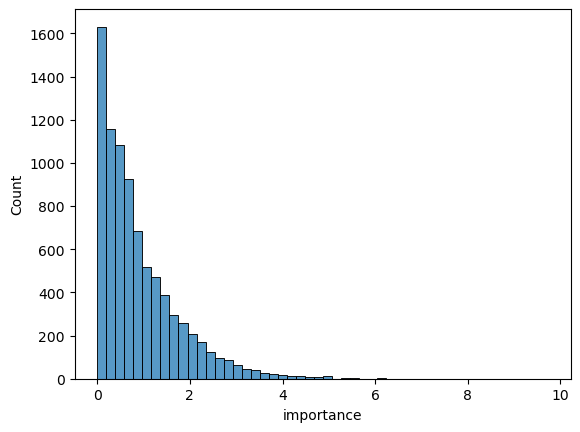

In [66]:
# visualize distribution of importance scores
sns.histplot(goi_grn['importance'], kde=False, bins=50)

In [67]:
# all regulons that have GOI in their target genes
goi_grn[goi_grn['target'] == GOI]

,target,importance,TF,group
593,VAV3,2.708242,KLF5,KLF5_regulon
662,VAV3,1.036355,CDX2,CDX2_regulon
372,VAV3,0.955606,ELF3,ELF3_regulon
557,VAV3,0.602913,EHF,EHF_regulon
51,VAV3,0.346808,ZBTB7A,ZBTB7A_regulon
381,VAV3,0.100496,PPARG,PPARG_regulon
25,VAV3,0.063045,ERF,ERF_regulon
1439,VAV3,0.061195,KLF4,KLF4_regulon


# Summary of GRN Data

In [68]:
# GOI text summary:

gg.GOI_network_stats(goi_grn, GOI)
gg.format_gene_summary(goi_grn, GOI)

Summary of VAV3:

There are 8 regulons that have VAV3 in their target genes.

Regulons that have VAV3 in their target genes:

	(TF: GENIE3 Importance Score)
	KLF5: 2.708
	CDX2: 1.036
	ELF3: 0.956
	EHF: 0.603
	ZBTB7A: 0.347
	PPARG: 0.1
	ERF: 0.063
	KLF4: 0.061


There are 84 TFs for VAV3 that were NOT supported by a regulon (motif analysis),
here are the top 10:

	(TF: GENIE3 Importance Score)
	UQCRB: 2.394
	PRDX5: 2.327
	SUCLG1: 2.018
	TPI1: 1.504
	CKMT1B: 1.206
	YBX1: 1.023
	ETFB: 1.005
	SATB2: 0.868
	CDX1: 0.863
	RPL6: 0.824
	MLXIP: 0.723

VAV3: 

	This gene is a member of the VAV gene family. The VAV
	proteins are guanine nucleotide exchange factors (GEFs) for Rho family GTPases that
	activate pathways leading to actin cytoskeletal rearrangements and transcriptional alterations. This gene
	product acts as a GEF preferentially for RhoG, RhoA, and to a
	lesser extent, RAC1, and it associates maximally with the nucleotide-free states of
	these GTPases. Alternatively spliced transcript 

The following regulons are present in relevant AUCell cellular-level analysis: ['ERF_REGULON']
Plotting cell-type specific expression or AUCell score for GOI and regulons


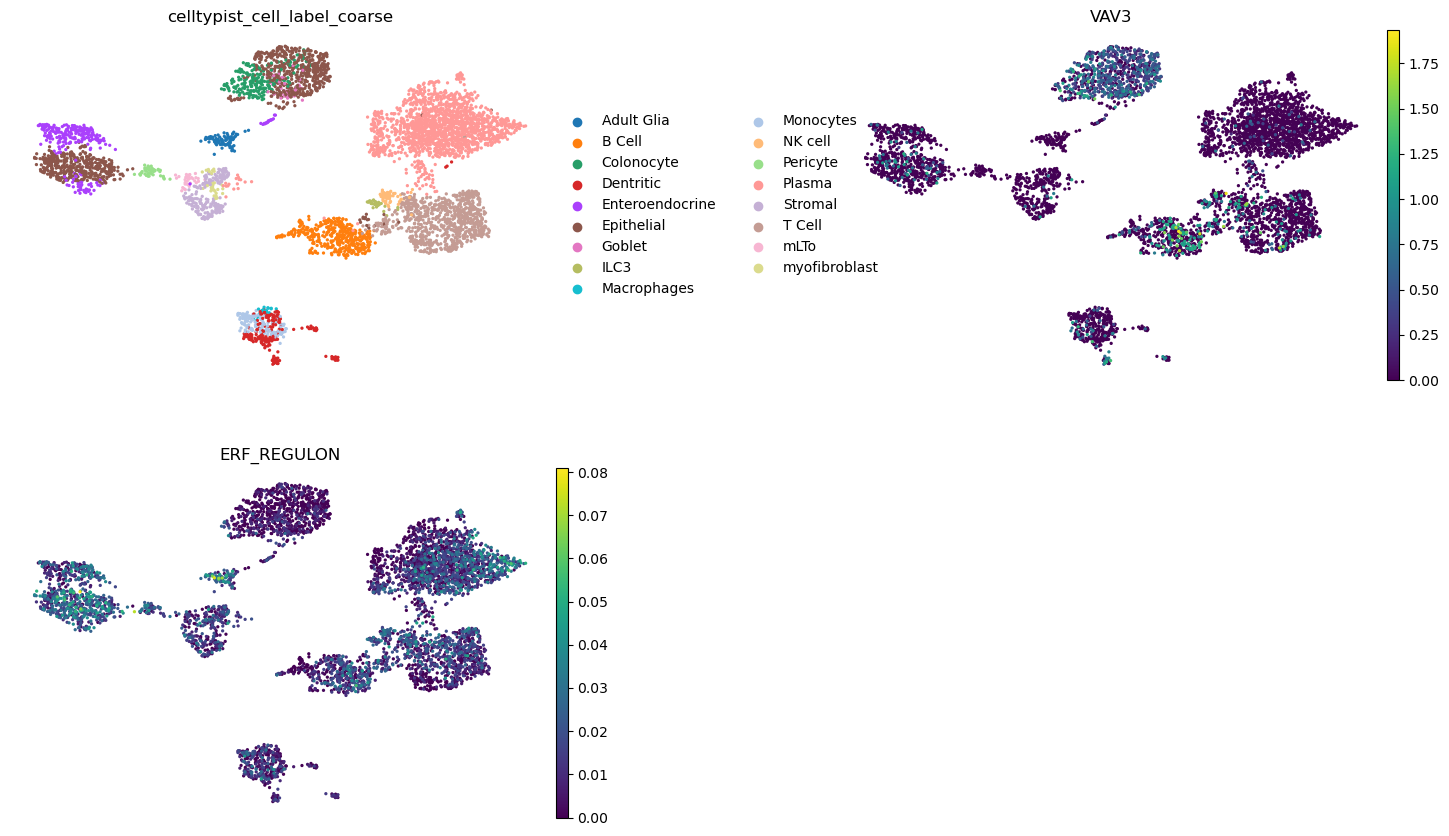

In [69]:
gg.plot_regulon_expression(goi_grn, GOI, adata)

# Network Visualization

In [70]:
gg.make_network(goi_grn)